# Train Bilateral Classifier

In [2]:
%load_ext autoreload
%autoreload 2

import sys
from os.path import join
import joblib
import torch
import pandas as pd

fp_code_folder = "../../"
fp_project_folder = join(fp_code_folder, "../")
sys.path.append(fp_code_folder)

fp_checkpoint_folder = join(fp_project_folder, "checkpoints")

from src.configs.image_config import fp_data_dfs_file, col_info
from src.preprocessing.pytorch_preprocessing import get_pytorch_split_dict, get_bc_image_dl
from src.pytorch_training.misc import set_seed_pytorch
from src.filepath_manager import FilePath
from src.models.resnet_bilateral.bc_trainer import train_resnet_bc
from src.models.resnet_bilateral.bc_inference import evaluate_resnet_bc
from src.models.resnet_bilateral.inference import get_pred_perf_df

fp = FilePath(model_name="resnet_bilateral_bc", fp_checkpoint_folder=fp_checkpoint_folder)
fp_ic_model_file = '../../../checkpoints/models/resnet_bilateral_ic/model.pt'

batch_size = 64
eval_batch_size = 64*4

seed_no = 2024

2025-02-19 11:44:00.238198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-19 11:44:00.249578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-19 11:44:00.253163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 11:44:00.262702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-19 11:44:00.886453: W tensorflow/compiler/tf2

### Load Data

In [4]:
data_dfs = joblib.load(fp_data_dfs_file)

In [5]:
set_seed_pytorch(seed_no)
data_dls = get_pytorch_split_dict(
    data_dict=data_dfs, col_info=col_info, 
    batch_size=batch_size, eval_batch_size=eval_batch_size, shuffle_train=True,
    dl_func=get_bc_image_dl
)

### Train BC

In [5]:
resnet_bilateral = torch.load(fp_ic_model_file)

Freezing Weights:
- conv1.weight frozen!
- bn1.weight frozen!
- bn1.bias frozen!
- layer1.0.conv1.weight frozen!
- layer1.0.bn1.weight frozen!
- layer1.0.bn1.bias frozen!
- layer1.0.conv2.weight frozen!
- layer1.0.bn2.weight frozen!
- layer1.0.bn2.bias frozen!
- layer1.1.conv1.weight frozen!
- layer1.1.bn1.weight frozen!
- layer1.1.bn1.bias frozen!
- layer1.1.conv2.weight frozen!
- layer1.1.bn2.weight frozen!
- layer1.1.bn2.bias frozen!
- 22122443 out of 22353675 parameters are trainable.


  0%|          | 0/2 [00:00<?, ?it/s]

/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/1 [00:00<?, ?it/s]

/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


=== Epoch 0, Time Taken: 21.1s, Time Left: 0.0s ===
- Train: Acc: 0.00000, Bce: 0.39927
- Valid: Acc: 0.00000, Bce: 0.49164


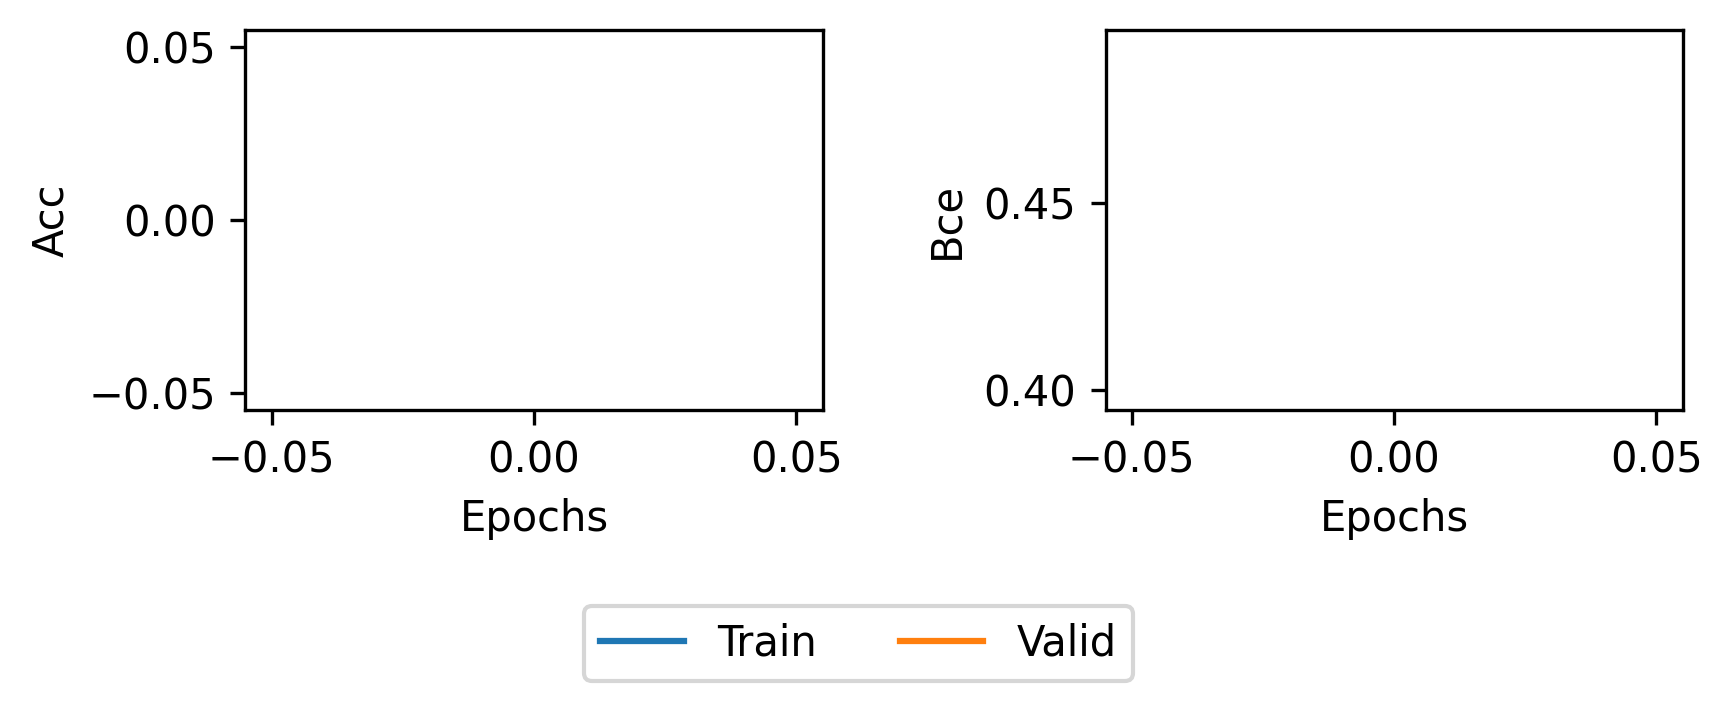

In [ ]:
ae_history = train_resnet_bc(
    model=resnet_bilateral, **data_dls, 
    fp_model=fp.fp_model_file, fp_history=fp.fp_history_file, # Where to store trained model and history of training
    max_epochs=500, 
    lr=0.0001, weight_decay=0.0001,  # Training parameters, # Smaller LR?
    patience=10, metric_to_monitor = "bce", maximise=False, # For early stopping
    verbose=True,
    seed = seed_no
) 

## Evaluate

In [3]:
resnet_bilateral = torch.load(fp.fp_model_file)

In [6]:
pred_df, perf_df = evaluate_resnet_bc(
    model=resnet_bilateral, dl=data_dls["test_dl"], col_info=col_info, verbose=True
)
pred_df.to_csv(fp.fp_prediction_file)
perf_df.to_csv(fp.fp_performance_file)

  0%|          | 0/14 [00:00<?, ?it/s]

In [3]:
pred_df = pd.read_csv(fp.fp_prediction_file, index_col=0)
get_pred_perf_df(pred_df, col_info)

,Acc,Class 0 Acc,Class 1 Acc,Class 2 Acc,Class 3 Acc,Class 4 Acc,Average Class Acc,Acc W/O Class 0
0,0.713792,0.889757,0.080808,0.4,0.411215,0.307692,0.417895,0.303263


In [7]:
perf_df = pd.read_csv(fp.fp_performance_file, index_col=0)
perf_df

,Acc,Class 0 Acc,Class 1 Acc,Class 2 Acc,Class 3 Acc,Class 4 Acc,Average Class Acc
0,0.713792,0.889757,0.080808,0.4,0.411215,0.307692,0.417895
